In [1]:
import righor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np

# useful if there's a weird error
# import os
# os.environ["RUST_BACKTRACE"] = "1"

# load the model
igor_model = righor.load_model("human", "trb")
# alternatively, you can load a model from igor files 
# igor_model = righor.load_model_from_files(params.txt, marginals.txt, anchor_v.csv, anchor_j.csv)

# constant error: all sequences have the same number of errors, here no errors
igor_model.error = righor.ErrorParameters.constant_error(0.0)
# uniform error: the number of error in the sequence is sequence-specific
# and inferred using the V gene (useful for sequences that undergo somatic hypermutation)
igor_model.error = righor.ErrorParameters.uniform_error()

In [2]:
nt_sequence = 'TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT'
aa_sequence = righor.n_to_aa(nt_sequence)
vgenes = righor.genes_matching('TRBV11-3*01', igor_model)
jgenes = righor.genes_matching('TRBJ1-6*02', igor_model)

result_inference = igor_model.evaluate((righor.Dna(nt_sequence), 
                                        vgenes, jgenes))
print(f"For the nucleotide sequence: {nt_sequence}")
print(result_inference)

# You can also access the most likely recombination event
print("Most likely recombination event: ")
event = result_inference.best_event
print(f"\tInsertion (VD): {event.ins_vd}")
print(f"\tInsertion (DJ): {event.ins_dj}")
print(f"\tD gene: {result_inference.best_d_gene}")
# more interestingly the "reconstructed sequence" without errors
print(f"\tReconstructed sequence:\n{result_inference.reconstructed_sequence}")



# all this also works with amino-acid sequences
print(f"\nFor the amino-acid sequence: {aa_sequence}")
result_inference = igor_model.evaluate((righor.AminoAcid(aa_sequence), 
                                        vgenes,
                                        jgenes))
print(result_inference)
print(f"\tReconstructed sequence:\n{result_inference.reconstructed_sequence}")

For the nucleotide sequence: TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT
Result:
	Likelihood: 7.04e-109, pgen: 6.45e-16
	Most likely event:
	- CDR3 (nucleotides): TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT 
	- CDR3 (amino acids): CASRKRRVTVVSPLHF 
	- V name: TRBV11-3*01 
	- J name: TRBJ1-6*02 
	- likelihood ratio: 0.0012130192886769132 
 
Most likely recombination event: 
	Insertion (VD): Dna(AA)
	Insertion (DJ): Dna(GTAACCGTGG)
	D gene: TRBD1*01
	Reconstructed sequence:
GAAGCTGGAGTGGTTCAGTCTCCCAGATATAAGATTATAGAGAAAAAACAGCCTGTGGCTTTTTGGTGCAATCCTATTTCTGGCCACAATACCCTTTACTGGTACCTGCAGAACTTGGGACAGGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGCAAGACAGGGGTAACCGTGGATTCACCCCTCCACTTTGGGAACGGGACCAGGCTCACTGTGACAG

For the amino-acid sequence: CASRKRRVTVVSPLHF
Result:
	Likelihood: 1.27e-106, pgen: 9.13e-10
	Most likely event:
	- CDR3 (nucleotides): TGYGCNWSNMGNAARMGNMGNGTNAC

In [8]:
## Generate sequences

# Create a generator object
generator = igor_model.generator(seed=42) # or igor_model.generator() to run it without a seed

# Generate 10'000 functional sequences (not out-of-frame, no stop codons, right boundaries)
for _ in tqdm(range(10000)):
    # generate_without_errors ignore Igor error model, use "generate" if this is needed
    sequence = generator.generate_without_errors(functional=True)
    if "IGH" in sequence.cdr3_aa:
        print("TRB CDR3 containing \"IGH\":", sequence.cdr3_aa)

print()

# Generate one sequence with a particular V/J genes family 
V_genes = righor.genes_matching("TRBV2", igor_model) # return all the V genes that match TRBV2
J_genes = righor.genes_matching("TRBJ", igor_model) # all the J genes
generator = igor_model.generator(seed=40, available_v=V_genes, available_j=J_genes) 
generation_result = generator.generate(functional=True)
print("Result:")
print(generation_result)
print("Explicit recombination event:")
print(generation_result.recombination_event)

  0%|          | 0/10000 [00:00<?, ?it/s]

TRB CDR3 containing "IGH": CASSMYLRDIGHTQYF
TRB CDR3 containing "IGH": CASSEKGGGQIGHSYEQYF

Result:
GenerationResult(
CDR3 (nucletides): TGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTC,
CDR3 (amino-acids): CASRRTANYGYTF,
Full sequence (nucleotides): GAACCTGAAGTCACCCAGACTCCCAGCCAT...,
V gene: TRBV2*01,
J gene: TRBJ1-2*01)
		 
Explicit recombination event:
StaticEvent(
nb. del. on V3: 12,
nb. del. on D5: 6,
nb. del. on D3: 9,
nb. del. on J5: 4,
V-D insertions: CGACG,
D-J insertions: ,
errors: None)


In [9]:
## Evaluate a given sequence
%env RUST_BACKTRACE=1
my_sequence = "GGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTTGGGAACGGGACCA"

# evaluate the sequence
result_inference = igor_model.evaluate(my_sequence)

# Most likely scenario
best_event = result_inference.best_event
print(result_inference)

print(f"Probability that this specific event chain created the sequence: {best_event.likelihood / result_inference.likelihood:.2f}.")
print(f"Reconstructed sequence (without errors):", best_event.reconstructed_sequence)
print(f"Pgen: {result_inference.pgen:.1e}")

env: RUST_BACKTRACE=1
Result:
	Likelihood: 1.08e-20, pgen: 1.08e-20
	Most likely event:
	- CDR3 (nucleotides): TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT 
	- CDR3 (amino acids): CASRKRRVTVVSPLHF 
	- V name: TRBV11-3*01 
	- J name: TRBJ1-6*02 
	- likelihood ratio: NaN 
 
Probability that this specific event chain created the sequence: nan.
Reconstructed sequence (without errors): Dna(GAAGCTGGAGTGGTTCAGTCTCCCAGATATAAGATTATAGAGAAAAAACAGCCTGTGGCTTTTTGGTGCAATCCTATTTCTGGCCACAATACCCTTTACTGGTACCTGCAGAACTTGGGACAGGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTTGGGAACGGGACCAGGCTCACTGTGACAG)
Pgen: 1.1e-20


In [3]:
# Inference of a model 
# use a very small number of sequences to keep short (still takes a few minutes)
# a good inference would take ≈ 10'000 sequences and a few hours on a laptop 
# (don't do it on a laptop)

# here we just generate the sequences needed
generator = igor_model.generator()
example_seq = generator.generate(False)
sequences = [generator.generate(False).full_seq for _ in range(100)]

align_params = righor.AlignmentParameters()
infer_params = righor.InferenceParameters()
# define parameters for the alignment and the inference 
# (can also be done for the evaluation)
# the default are generally fine
# longer V gene cut-off improve the alignment but slower
# align_params.left_v_cutoff = 90
# define the likelihood cutoff (higher: less precise but faster)
# infer_params.min_ratio_likelihood = 1e-4
# infer_params.min_likelihood = 1e-20

# generate an uniform model as a starting point 
# (it's generally much better to use an already inferred model as the starting point)
model = igor_model.copy().uniform()

# multiple round of expectation-maximization to infer the model
models = {}
model = igor_model.uniform()
models[0] = model
for ii in tqdm(range(20)):
    models[ii+1] = models[ii].copy()
    models[ii+1].infer(sequences,
                       align_params,
                       infer_params)

  0%|          | 0/20 [00:00<?, ?it/s]

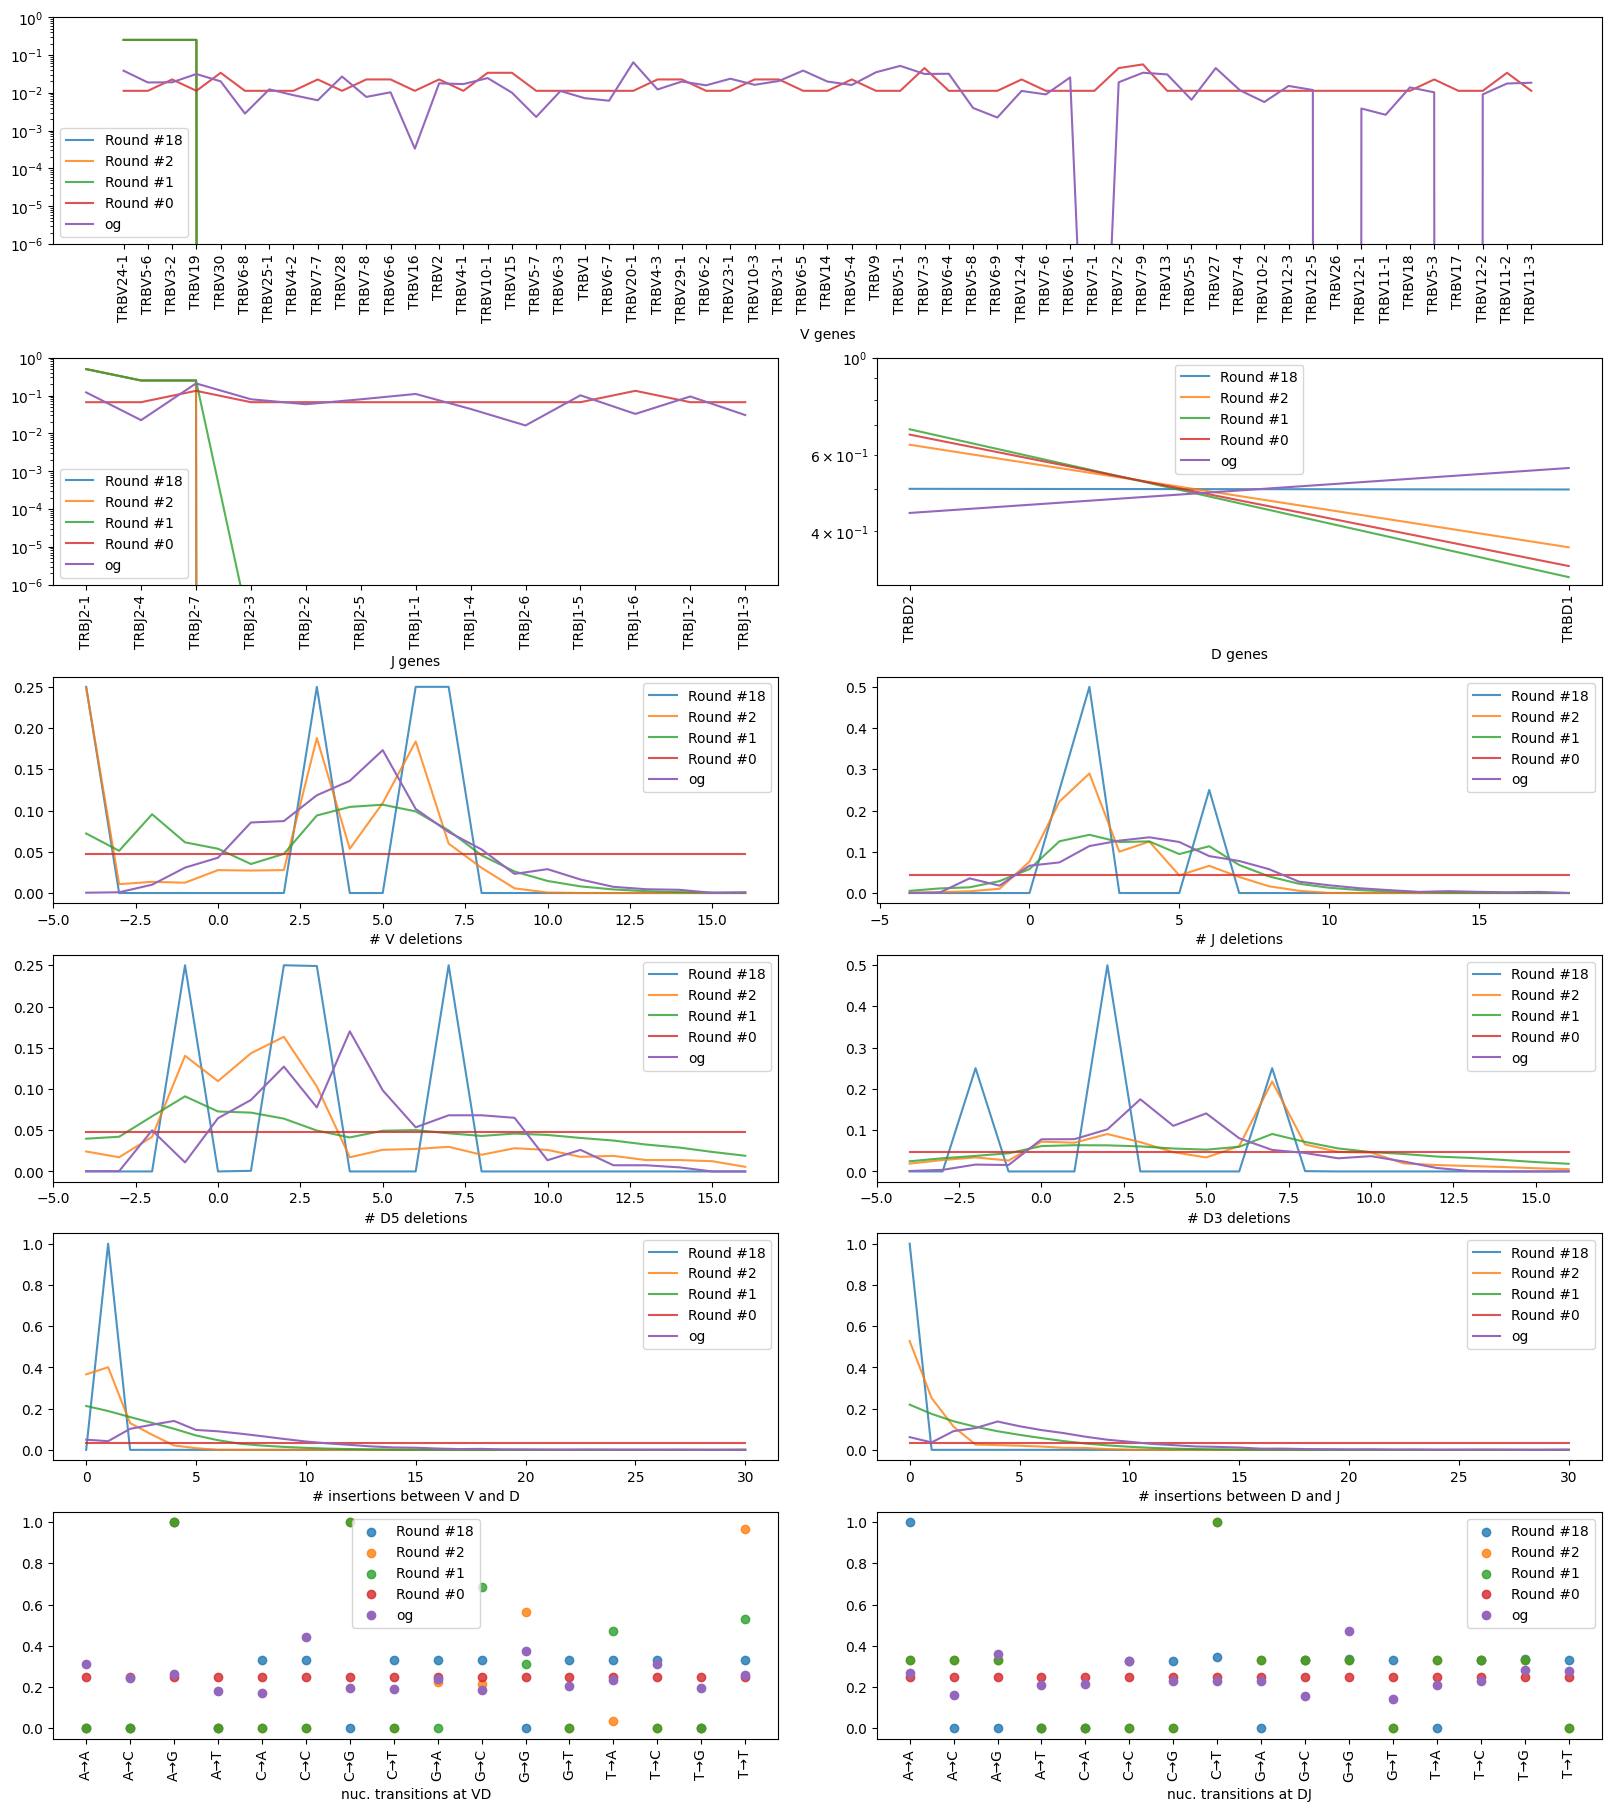

In [4]:
# visualisation of the results
fig = righor.plot_vdj(*[models[ii] for ii in [10, 2, 1, 0]] + [igor_model],
            plots_kws=[{'label':f'Round #{ii}', 'alpha':0.8} for ii in [18,2, 1, 0]] + [{'label':f'og'}] )


In [3]:
igor_model = righor.load_model_from_files(json='test_save.json')

In [ ]:
# save the model in the Igor format (4 files in a directory)
# will return an error if the directory already exists
models[10].save_model('test_save')
# load the model
igor_model = righor.load_model_from_files('test_save/model_params.txt',
                                          'test_save/model_marginals.txt',
                                          'test_save/V_gene_CDR3_anchors.csv',
                                          'test_save/J_gene_CDR3_anchors.csv')

# save the model in json format (1 file in a directory)
models[10].save_json('test_save.json')
# load the model in json
igor_model = righor.load_from_files(json='test_save.json')